## Beginner Feature Visualization Tutorial

First, preliminary imports.
note: cite other places to find FVs (captum, lucent, etc.)

In [1]:
from deep_data_profiler.optimization import dictionary_optimization

In [2]:
from torchvision.models import resnet18
import torch


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = resnet18(pretrained=True)
_ = model.to(device).eval()

### The easiest function to use for feature visualization is `dictionary_optimization`.  This tutorial covers the use of this function.

It reads a dictionary of either `{layer : [neurons...]}` or `{layer : [(neuron, weight), ...]}`
and returns a single objective to optimize. It also accepts a (namely, Euclidean or SVD), 
and whether to consider a single receptive field or the entire channel/signal.


For this first example, we use `{layer : [neurons...]}`, where `neurons` defines a single element from the signal (a slight wrinkle, to keep the indexing consistent between the "SVD" basis and the Euclidean basis, is that the index for the signal is `(signal number, x position, y position)`, where x and y are defined by reshaping the signal vector back to the original `channel x height x width dimensions`). 

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [01:10<00:00,  7.24it/s]



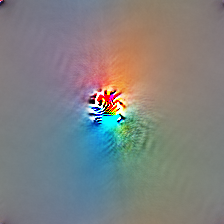

In [7]:
signals_receptive_fields_weights = {
    "conv1": [((0, 1, 1)), ((20, 1, 1))],
    "layer1.0.conv2": [((50,)), ((13, 1, 1))],
}


_ = dictionary_optimization(model, signals_receptive_fields_weights)

For this example, we use `{layer : [(neuron, weight), ...]}`, where `neurons` is the same as above and weight now defines a linear weighting in the optimizaiton. For the example below, for the layer `conv1`, we are weighting the signal `0` at position `x=1, y=1`, i.e. SVD neuron `(0, 1, 1)` by `10`, and we are weighting the SVD neuron `(20, 1, 1)` by `1`. So, the first neuron `(0, 1, 1)` is weighted `10` times the second neuron `(20, 1, 1)`. The same logic holds for the neurons on the layer `layer1.0.conv2`.

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [01:09<00:00,  7.37it/s]



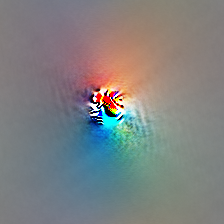

In [4]:
signals_receptive_fields_weights = {
    "conv1": [((0, 1, 1), 10), ((20, 1, 1), 1)],
    "layer1.0.conv2": [((50,), 10), ((13,), 1)],
}


_ = dictionary_optimization(model, signals_receptive_fields_weights)

We now consider examples optimizing for an entire channel/SVD signal. For this optimization, we set `neuron=False` in `dictionary_optimization`. Now, we use a single scalar to index the signal. For the example below, we are optimizing for the `0` and `20` signals at layer `conv1`, and for layer `layer1.0.conv2` the `50` and `13` signals.

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [01:08<00:00,  7.52it/s]



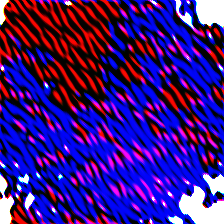

In [3]:
# layer_signals_weights = {"conv1": [((0, ), 10), ((20, ), 5)], "layer1.0.conv2": [((50,), 10), ((13,), 5)]}
layer_signals_weights = {"conv1": [0, 20], "layer1.0.conv2": [50, 13]}

_ = dictionary_optimization(model, layer_signals_weights, neuron=False)

Finally, we can also perform weighted optimization for these signals. We are again passing a dictionary of the form `{layer : [(neuron, weight), ...]}`. Below, for layer `conv1`, we are optimizing neurons `0` and `20` with weights of `0` (i.e. not optimizing for this neuron at all) and `5`, respectively.

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [01:10<00:00,  7.22it/s]



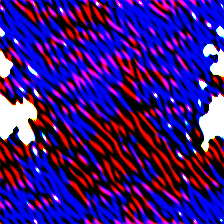

In [6]:
layer_signals_weights = {"conv1": [(0, 0), (20, 5)], "layer1.0.conv2": [(50, 10), (13, 0)]}

_ = dictionary_optimization(model, layer_signals_weights, neuron=False)

### We can do the same for the non-transformed activations (i.e. "Euclidean" basis, or just the channel slices or neurons) by setting `neuron_type=NeuronBasis.ACTIVATION`.

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:50<00:00, 10.22it/s]



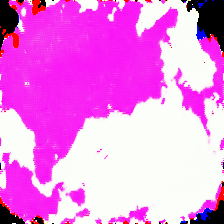

In [3]:
from deep_data_profiler.optimization import NeuronBasis


layer_signals_weights = {"conv1": [0, 4]}

_ = dictionary_optimization(model, layer_signals_weights, neuron_type=NeuronBasis.ACTIVATION, neuron=False)

Like above, we can also provide weights to the Euclidean basis optimizations.

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:50<00:00, 10.20it/s]



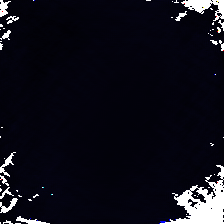

In [4]:
from deep_data_profiler.optimization import NeuronBasis


layer_signals_weights = {"conv1": [(0, 1), (20, 5)]}

_ = dictionary_optimization(model, layer_signals_weights, neuron_type=NeuronBasis.ACTIVATION, neuron=False)